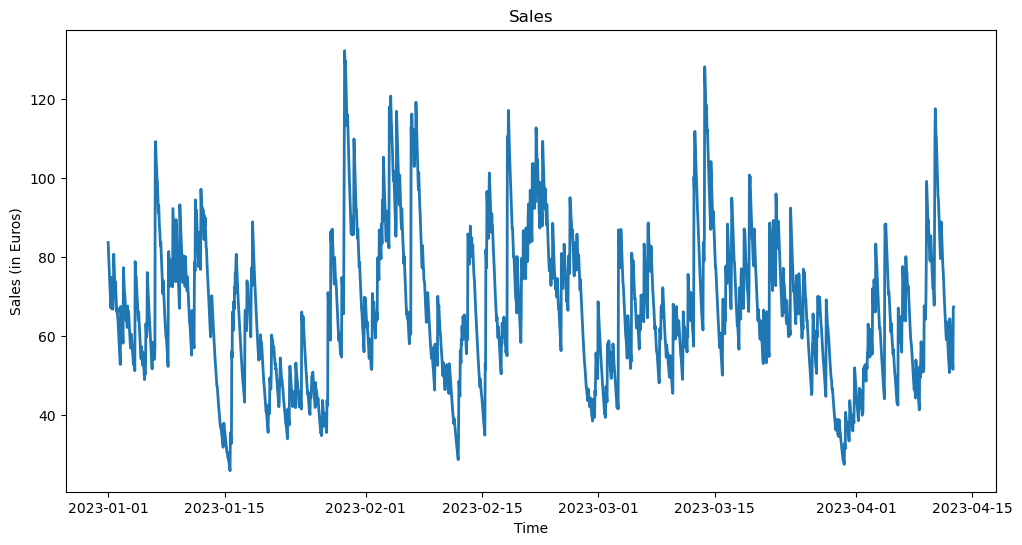

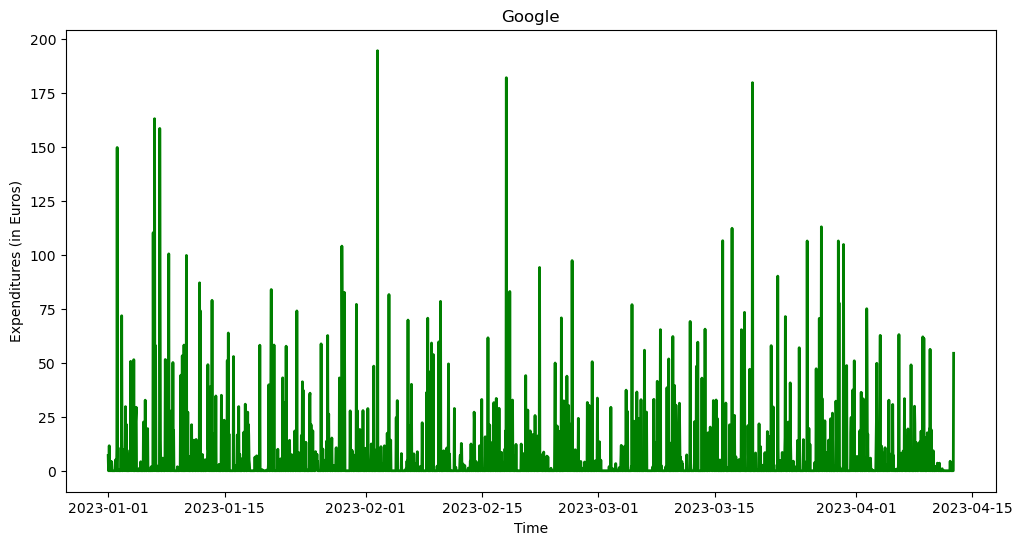

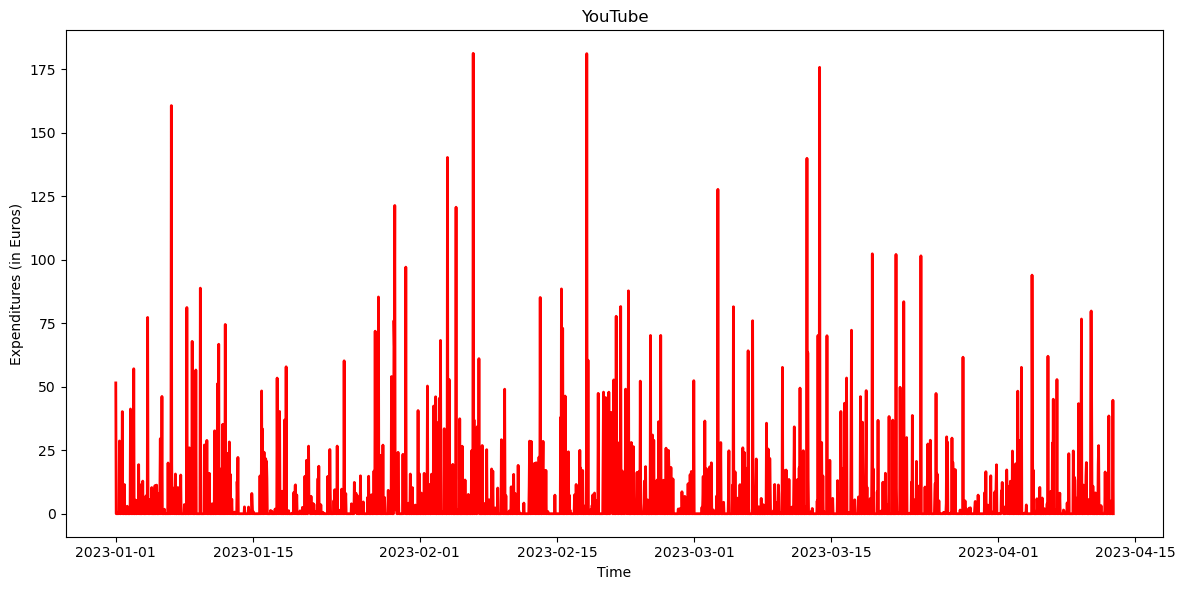

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize, fmin_slsqp
import matplotlib.ticker as plticker
import math
import warnings
warnings.filterwarnings('ignore')
#Jaspreet Singh 2710547, Adam Hattata 2708739, John Mossaad 2792444, Ayman Maddaghri 2703656
df = pd.read_csv('marketing_data.csv')

# Extract columns
st = df['s']
gt = df['g']
yt = df['y']

time_index = pd.date_range(start='2023-01-01', periods=len(df), freq='H')

# Create separate figures and axes for each plot
fig1, ax1 = plt.subplots(figsize=(12, 6))
fig2, ax2 = plt.subplots(figsize=(12, 6))
fig3, ax3 = plt.subplots(figsize=(12, 6))

# Plot sales
ax1.plot(time_index, st, linewidth=2)
ax1.set_xlabel('Time')
ax1.set_ylabel('Sales (in Euros)')
ax1.set_title('Sales')

# Plot Google search expenditures
ax2.plot(time_index, gt, 'g', linewidth=2)
ax2.set_xlabel('Time')
ax2.set_ylabel('Expenditures (in Euros)')
ax2.set_title('Google')

# Plot YouTube expenditures
ax3.plot(time_index, yt, 'r', linewidth=2)
ax3.set_xlabel('Time')
ax3.set_ylabel('Expenditures (in Euros)')
ax3.set_title('YouTube')

# Display the plots
plt.tight_layout()
plt.show()


In [2]:
def model(params, gt, yt, i):
    mu, phi1, phi2, delta1, delta2, alpha1, alpha2, beta1, beta2 = params
    
    gads = np.zeros(i)
    gads[0] = 0
    yads = np.zeros(i)
    yads[0] = 0
    s_hat = np.zeros(i)
    
    for t in range(1, i):
        gads[t] = beta1 * gads[t-1] + alpha1 * gt[t-1]
        yads[t] = beta2 * yads[t-1] + alpha2 * yt[t-1]
        s_hat[t] = mu + phi1 * (gads[t]**delta1) + phi2 * (yads[t]**delta2)
    
    LS = (1/i) * np.sum((np.array(gt) - s_hat)**2)
    
    return LS, s_hat, gads, yads


# Define the bounds for optimization
params_ini = [1, 1, 1, 0.5, 0.5, 5, 5, 0.9, 0.9]
Positive_bounds = (0.0001, None)
ZerotoOne = (0.0001, 1)
Bounds = [Positive_bounds] * 3 + [ZerotoOne] * 2 + [Positive_bounds] * 2 + [ZerotoOne] * 2

# Define the average LS function for optimization
avg_LS = lambda params: model(params, gt, yt, len(st))[0]

# Use the optimizer to find the optimal parameters
result = minimize(avg_LS, params_ini, method="L-BFGS-B", bounds=Bounds, options={'disp': True})

print("Parameter estimates:")
estimates = result.x
param_names = ["mu", "phi1", "phi2", "delta1", "delta2", "alpha1", "alpha2", "beta1", "beta2"]

for name, value in zip(param_names, estimates):
    formatted_value = "{:.3f}".format(value)
    print(f"{name}: {formatted_value}")


Parameter estimates:
mu: 1.321
phi1: 1.591
phi2: 0.011
delta1: 0.125
delta2: 1.000
alpha1: 7.042
alpha2: 6.912
beta1: 0.969
beta2: 0.126


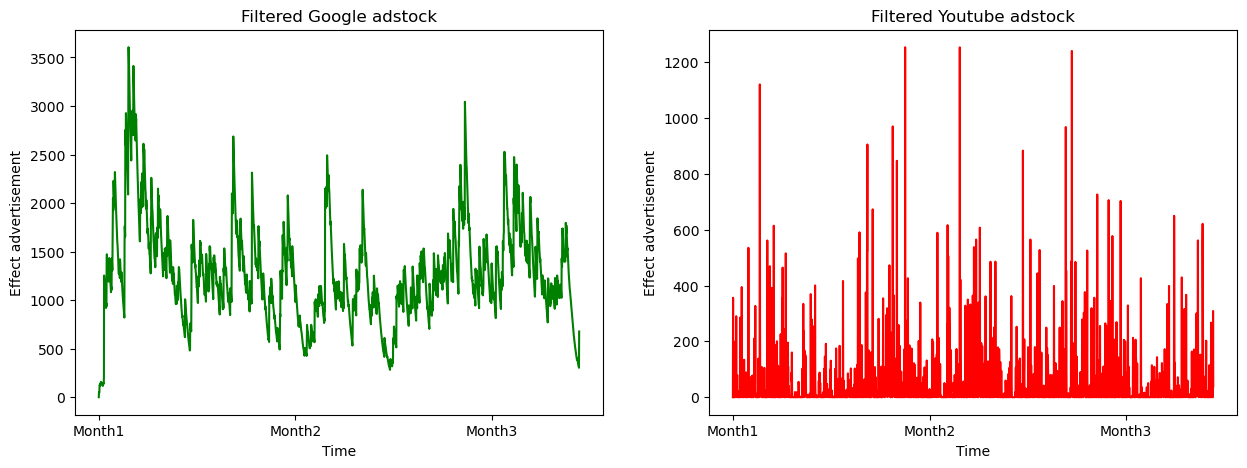

In [3]:
gads = np.zeros(len(st) + 1)
yads = np.zeros(len(st) + 1)
alpha1 = estimates[-4]
alpha2 = estimates[-3]
beta1 = estimates[-2]
beta2 = estimates[-1]

for t in range(len(st)):
    gads[t + 1] = beta1 * gads[t] + alpha1 * gt[t]
    yads[t + 1] = beta2 * yads[t] + alpha2 * yt[t]

label = ['Month1', 'Month2', 'Month3']
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set(xlabel="Time", ylabel="Effect advertisement")
ax1.set_title("Filtered Google adstock")
ax1.set_xticks(np.arange(0, len(df), 1000))
ax1.set_xticklabels(label)
ax1.plot(gads, color='g')

ax2.set_title("Filtered Youtube adstock")
ax2.set(xlabel="Time", ylabel="Effect advertisement")
ax2.set_xticks(np.arange(0, len(df), 1000))
ax2.set_xticklabels(label)
ax2.plot(yads, color='r')


plt.show()

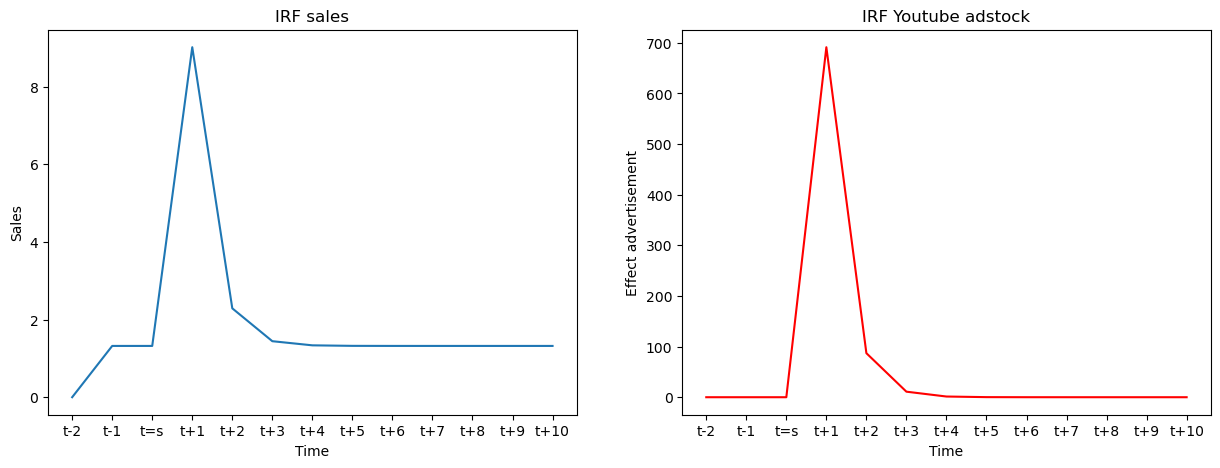

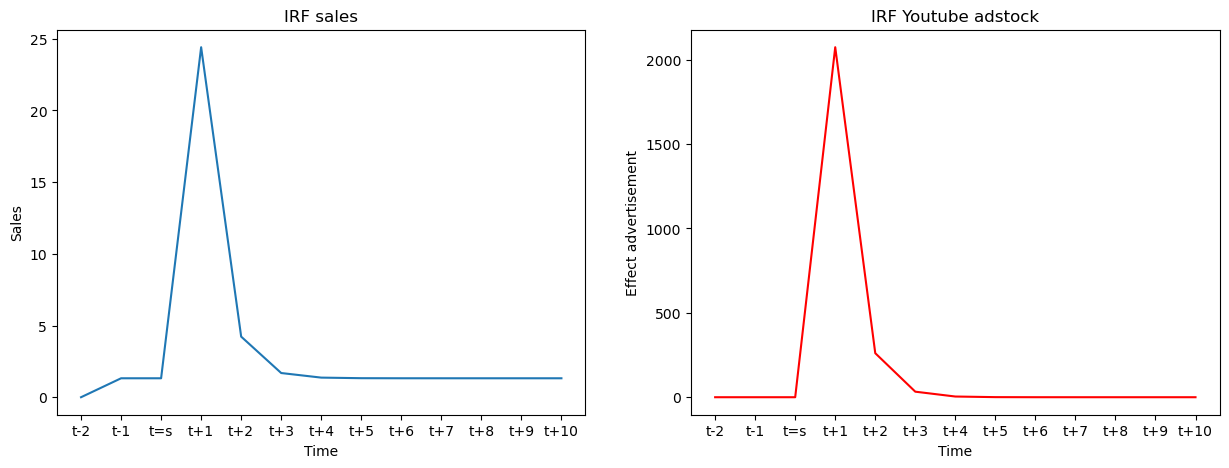

In [4]:
def IRF(estimates, dImpulse):
    i = 13
    gt = np.zeros(i)
    yt = np.zeros(i)
    yt[2] = dImpulse
    LS, vIRF1, _, vIRF2 = model(estimates, gt, yt, i)
    
    label=['t-2','t-1','t=s','t+1','t+2','t+3','t+4','t+5','t+6','t+7','t+8','t+9','t+10']

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set(xlabel="Time", ylabel="Sales")
    ax1.set_title("IRF sales")
    ax1.set_xticks(np.arange(i))
    ax1.set_xticklabels(label)
    ax1.plot(vIRF1)
    
    ax2.set_title("IRF Youtube adstock")
    ax2.set(xlabel="Time", ylabel="Effect advertisement")
    ax2.set_xticks(np.arange(i))
    ax2.set_xticklabels(label)
    ax2.plot(vIRF2, color="r")
    
    plt.show()

IRF(estimates, 100)
IRF(estimates, 300)

In [5]:
s = 25
gt = np.zeros(len(df))
yt = np.zeros(len(df))
yt[s] = 100
mu_hat = estimates[0]
s_hat = model(estimates, gt, yt, len(df))[1]
additional_sales = sum(s_hat) - (mu_hat * len(df))
print("Expected accumulated additional sales by impulse of €100 on YouTube: ", math.floor(additional_sales))

yt[s] = 300
s_hat = model(estimates, gt, yt, len(df))[1]
additional_sales = sum(s_hat) - (mu_hat * len(df))
print("Expected accumulated additional sales by impulse of €300 on YouTube: ", math.floor(additional_sales))


Expected accumulated additional sales by impulse of €100 on YouTube:  7
Expected accumulated additional sales by impulse of €300 on YouTube:  25


In [6]:
def plot_data(data): 
    Columns = data.columns.values 
    f, ax = plt.subplots(2, 2, figsize=(11, 11))
    h = 0
    header = ["Sales", "Selling price", "Marketing expenditures", "Acquisition cost"]
    label2 = ["Sales", "Price", "Expenditures", "Costs"]
    
    for i in range(2):
        for j in range(2):
            ax[i][j].set(xlabel="Time", ylabel=label2[h])
            ax[i][j].set_title(header[h])
            ax[i][j].plot(data[Columns[h]])
            h += 1

def OLS(x, y):
    x = sm.add_constant(x)
    est = sm.OLS(y.astype(float), x.astype(float)).fit()
    print(est.summary())
    return est

data = pd.read_csv("pricing_data.csv")
Columns = data.columns.values

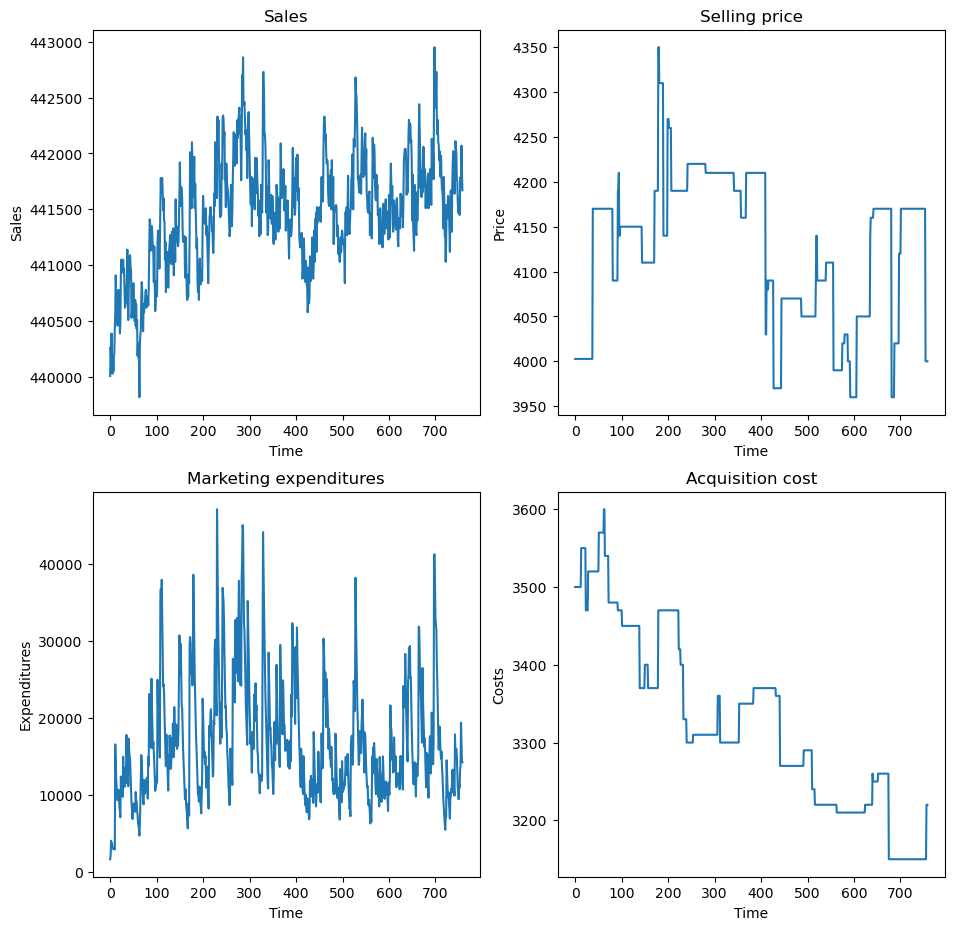

In [7]:
plot_data(data)

In [8]:
est = OLS(data[Columns[1]], data[Columns[0]])
bSe1 = est.bse[1]
beta1 = est.params[1]
print(est.bse)

                            OLS Regression Results                            
Dep. Variable:                      s   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     44.58
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           4.73e-11
Time:                        11:49:15   Log-Likelihood:                -5770.6
No. Observations:                 759   AIC:                         1.155e+04
Df Residuals:                     757   BIC:                         1.155e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.355e+05    892.010    488.237      0.0

In [9]:
print("Parameter estimates are: ", est.params)

Parameter estimates are:  const    435512.456670
p             1.442718
dtype: float64


In [10]:
# Perform instrumental regression
est_instrumental = OLS(data[Columns[3]], data[Columns[1]])
Params = est_instrumental.params.values

# Print parameter values for instrumental regression
print("Parameter values instrumental regression:", est_instrumental.params)

# Calculate pt_hat using the instrumental regression parameters
pt_hat = Params[0] + Params[1] * data[Columns[3]]

# Perform sales regression using pt_hat
est_sales = OLS(pt_hat, data[Columns[0]])
bSe2 = est_sales.bse[1]
beta2 = est_sales.params[1]

# Print parameter values for sales regression
print("Parameter values sales regression:", est_sales.params)

                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     31.70
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           2.53e-08
Time:                        11:49:15   Log-Likelihood:                -4402.0
No. Observations:                 759   AIC:                             8808.
Df Residuals:                     757   BIC:                             8817.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3653.8097     84.139     43.426      0.0

In [11]:
durbin = (np.sqrt(len(data)) * np.abs((beta2 - beta1))) / np.sqrt((bSe2**2) - (bSe1**2))
print("Durbin-Watson statistic: {:.3f}".format(durbin))

Durbin-Watson statistic: 671.738


In [12]:
data["p_hat"] = pt_hat
col = ['m', 'p_hat']
est = OLS(data[col], data[Columns[0]])
print("Parameter estimates are: ", est.params)

                            OLS Regression Results                            
Dep. Variable:                      s   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     2101.
Date:                Mon, 09 Oct 2023   Prob (F-statistic):          1.85e-309
Time:                        11:49:15   Log-Likelihood:                -5078.6
No. Observations:                 759   AIC:                         1.016e+04
Df Residuals:                     756   BIC:                         1.018e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.127e+05   1795.246    285.563      0.0

In [14]:
pt = data["p"].values[-10:]
mt = data["m"].values[-10:]
ct = data["c"].values[-10:]
Est = lambda parameter, p, m, c: (parameter[0] + parameter[1] * p + parameter[2] * m) * (p - c)
es = Est(est.params, pt[-1], mt[-1], ct[-1])
esUnit_incr = Est(est.params, pt[-1] + 1, mt[-1], ct[-1])

print("The causal effect on expected profit of unit increase in price: {:.3f}".format(esUnit_incr - es))

The causal effect on expected profit of unit increase in price: 264504.705
